In [2]:
import sys
sys.path.append('/Users/vdk/Software/code/')
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.io import EventSource
from astropy.table import Table, vstack
from ctapipe.visualization import CameraDisplay
import pandas as pd
import glob
from astropy import units as u
from python_modules.muonpipe import usefull_func


filename = '/Users/vdk/muons2024/lapalma_simulations/simtel/zenith10/run101_muon.simtel.gz'
source = EventSource(filename, max_events = 5000)
event_iterator = iter(source)
        
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#e377c2',  # raspberry yogurt pink
    '#8c564b',  # chestnut brown
    'k'
]

## Load pedestals for simulation

In [3]:
sim_pedestal_1 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/pedestal_sim_event100.txt')
sim_pedestal_2 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/pedestal_sim_event101.txt')
sim_pedestal_3 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/pedestal_sim_event102.txt')

data_pedestal_1 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/pedestal_data_event1200643.txt')
data_pedestal_2 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/pedestal_data_event1200647.txt')
data_pedestal_3 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/pedestal_data_event1200651.txt')

data_dc_to_pe_1 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/dc_to_pe_data_event1200643.txt')
data_dc_to_pe_2 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/dc_to_pe_data_event1200647.txt')
data_dc_to_pe_3 = np.loadtxt('/Users/vdk/muons2024/data/17043/real_data/array_pedestals/dc_to_pe_data_event1200651.txt')

In [4]:
sim_pedestal_1.shape

(2, 1855)

#### Simulation pedestal processing

**Simtel file is processed with `eventio` class, that creates instance of `array_event` for each `event`:**

```python
pedestal = array_event["camera_monitorings"][tel_id]["pedestal"] / array_event["camera_monitorings"][tel_id]["n_ped_slices"]
dc_to_pe = array_event["laser_calibrations"][tel_id]["calib"]
```

**Then the R0 waveforms are converted into `R1 waveforms` by substracting this `pedestal` and multiplying by `dc_to_pe` array:**

```python
calib_shift = 1
r1_waveforms = (r0_waveforms - pedestal) * dc_to_pe + calib_shift
```

### Data pedestal processing


**Trace of the procedures that change the waveform values**

1. First of all, before all other procedures, there are subtracting of the offset from the `r0 waveform`:

```python
scale = self.data_stream.waveform_scale = 1
offset = self.data_stream.waveform_offset = 400
waveform = raw_waveform.astype(np.float32) / scale - offset
```

2. Then there is happening `drs4_corrections`

3. And now it is time for `pedestal` subtraction and `dc_to_pe` conversion:

```python
waveform -= calibration.pedestal_per_sample[selected_gain_channel, PIXEL_INDEX, np.newaxis]
waveform *= calibration.dc_to_pe[selected_gain_channel, PIXEL_INDEX, np.newaxis]
```

**Pedestal values are taken from the pedestal calibration file, which is created at the beginning of each night.** `calibration_filters_52.Run17017.0000.h5`

=========================HIGH GAIN==============================

Mean of pedestal distribution in sim 400.016 wit std = 0.661
Mean of pedestal distribution in data 398.56 with std = 0.374

=========================LOW GAIN==============================

Mean of pedestal distribution in sim 400.006 wit std = 0.498
Mean of pedestal distribution in data 399.957 with std = 0.291


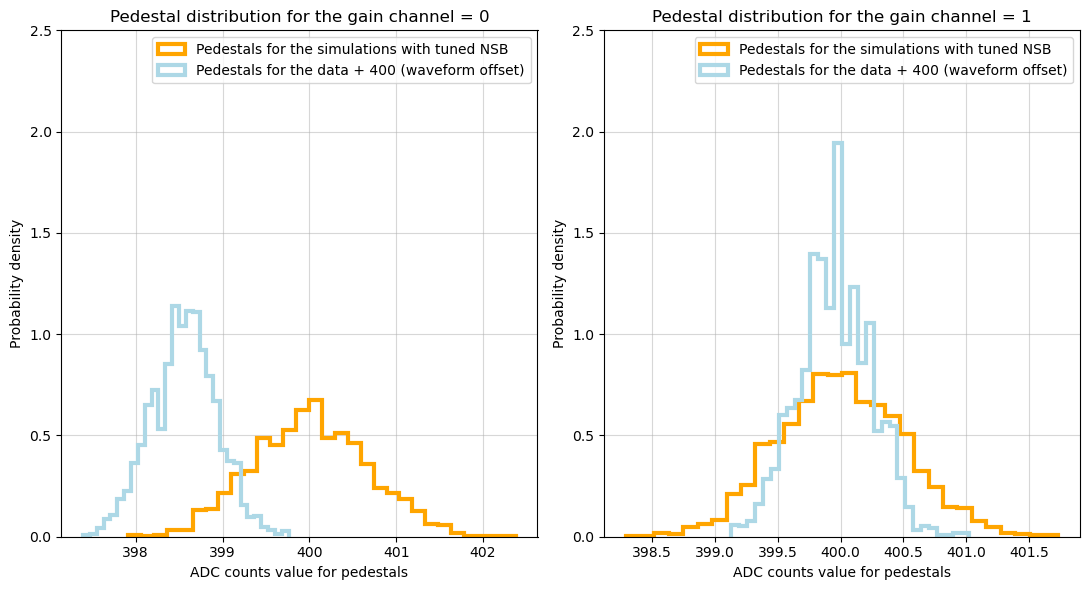

In [90]:
channel_0 = 0
channel_1 = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

# Plot for channel 0
ax1.hist(sim_pedestal_1[channel_0], histtype='step', bins=30, density=True)
ax1.hist(sim_pedestal_2[channel_0], histtype='step', bins=30, density=True)
ax1.hist(sim_pedestal_3[channel_0], histtype='step', bins=30, density=True, label='Pedestals for the simulations with tuned NSB', linewidth=3, color = 'orange')

ax1.hist(data_pedestal_1[channel_0] + 400, histtype='step', bins=30, density=True)
ax1.hist(data_pedestal_2[channel_0] + 400, histtype='step', bins=30, density=True)
ax1.hist(data_pedestal_3[channel_0] + 400, histtype='step', bins=30, density=True, label='Pedestals for the data + 400 (waveform offset)', linewidth=3, color = 'lightblue')

ax1.grid(alpha=0.5)
ax1.set_xlabel("ADC counts value for pedestals")
ax1.set_ylabel("Probability density")
ax1.legend()
ax1.set_ylim(0, 2.5)
ax1.set_title(f'Pedestal distribution for the gain channel = {channel_0}')

# Plot for channel 1
ax2.hist(sim_pedestal_1[channel_1], histtype='step', bins=30, density=True)
ax2.hist(sim_pedestal_2[channel_1], histtype='step', bins=30, density=True)
ax2.hist(sim_pedestal_3[channel_1], histtype='step', bins=30, density=True, label='Pedestals for the simulations with tuned NSB', linewidth=3, color = 'orange')

ax2.hist(data_pedestal_1[channel_1] + 400, histtype='step', bins=30, density=True)
ax2.hist(data_pedestal_2[channel_1] + 400, histtype='step', bins=30, density=True)
ax2.hist(data_pedestal_3[channel_1] + 400, histtype='step', bins=30, density=True, label='Pedestals for the data + 400 (waveform offset)', linewidth=3, color = 'lightblue')

ax2.grid(alpha=0.5)
ax2.set_xlabel("ADC counts value for pedestals")
ax2.set_ylabel("Probability density")
ax2.legend()
ax2.set_ylim(0, 2.5)
ax2.set_title(f'Pedestal distribution for the gain channel = {channel_1}')

print(f'=========================HIGH GAIN==============================\n')
print(f'Mean of pedestal distribution in sim {round(np.mean(sim_pedestal_1[channel_0]),3)} wit std = {round(np.std(sim_pedestal_1[channel_0]),3)}')
print(f'Mean of pedestal distribution in data {round(np.mean(data_pedestal_1[channel_0]+400),3)} with std = {round(np.std(data_pedestal_1[channel_0]+400),3)}')
print(f'\n=========================LOW GAIN==============================\n')
print(f'Mean of pedestal distribution in sim {round(np.mean(sim_pedestal_1[channel_1]),3)} wit std = {round(np.std(sim_pedestal_1[channel_1]),3)}')
print(f'Mean of pedestal distribution in data {round(np.mean(data_pedestal_1[channel_1]+400),3)} with std = {round(np.std(data_pedestal_1[channel_1]+400),3)}')

plt.tight_layout()
plt.show()


Mean of pedestal distribution in sim 400.006 wit std = 0.498
Mean of pedestal distribution in data 399.957 with std = 0.291


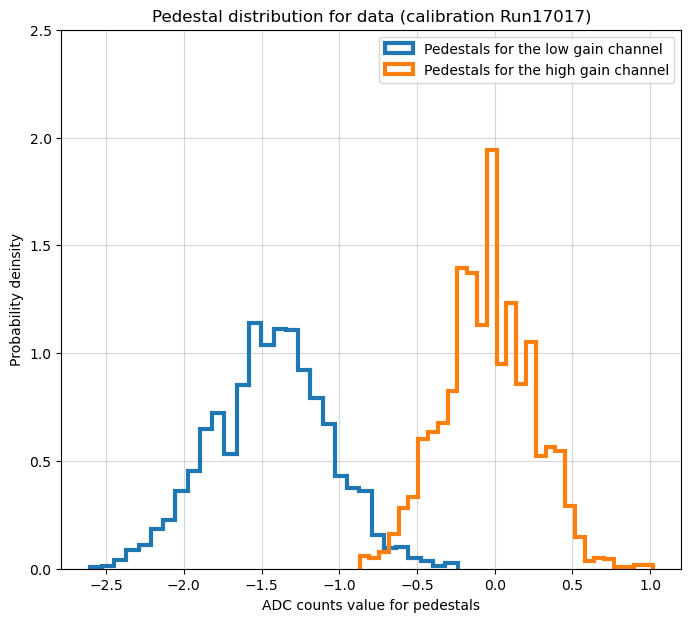

In [6]:
channel = 1
plt.figure(figsize=(8,7))

z,x,c = plt.hist(data_pedestal_3[0], histtype = 'step', bins = 30, density = True, label = 'Pedestals for the low gain channel', linewidth = 3)

z,x,c = plt.hist(data_pedestal_3[1], histtype = 'step', bins = 30, density = True, label = 'Pedestals for the high gain channel', linewidth = 3)

plt.grid(alpha = 0.5)
plt.xlabel("ADC counts value for pedestals")
plt.ylabel("Probability deinsity")
plt.legend()
plt.ylim(0,2.5)
plt.title(f'Pedestal distribution for data (calibration Run17017)')
print(f'Mean of pedestal distribution in sim {round(np.mean(sim_pedestal_1[channel]),3)} wit std = {round(np.std(sim_pedestal_1[channel]),3)}')
print(f'Mean of pedestal distribution in data {round(np.mean(data_pedestal_1[channel]+400),3)} with std = {round(np.std(data_pedestal_1[channel]+400),3)}')

Mean of pedestal distribution in sim 400.006 wit std = 0.498
Mean of pedestal distribution in data 399.957 with std = 0.291


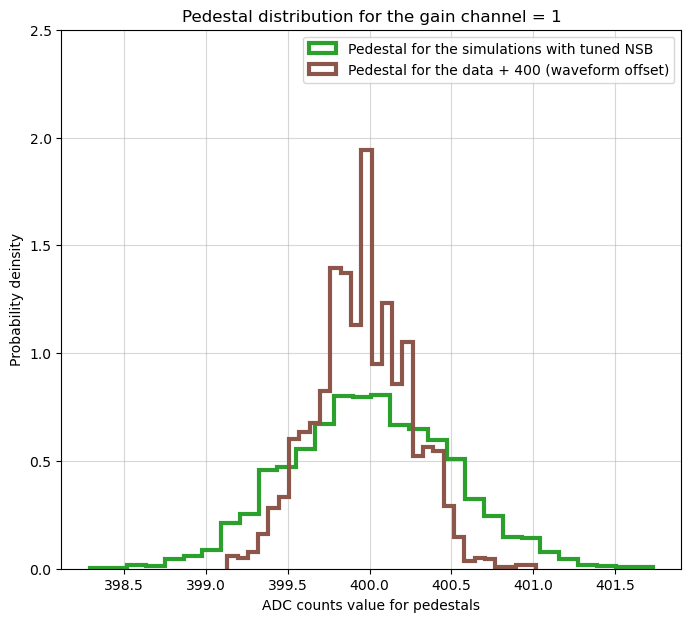

In [67]:
channel = 1
plt.figure(figsize=(8,7))
z,x,c = plt.hist(sim_pedestal_1[channel], histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(sim_pedestal_2[channel], histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(sim_pedestal_3[channel], histtype = 'step', bins = 30, density = True, label = 'Pedestal for the simulations with tuned NSB', linewidth = 3)

z,x,c = plt.hist(data_pedestal_1[channel]+400, histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(data_pedestal_2[channel]+400, histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(data_pedestal_3[channel]+400, histtype = 'step', bins = 30, density = True, label = 'Pedestal for the data + 400 (waveform offset)', linewidth = 3)

plt.grid(alpha = 0.5)
plt.xlabel("ADC counts value for pedestals")
plt.ylabel("Probability deinsity")
plt.legend()
plt.ylim(0,2.5)
plt.title(f'Pedestal distribution for the gain channel = {channel}')
print(f'Mean of pedestal distribution in sim {round(np.mean(sim_pedestal_1[channel]),3)} wit std = {round(np.std(sim_pedestal_1[channel]),3)}')
print(f'Mean of pedestal distribution in data {round(np.mean(data_pedestal_1[channel]+400),3)} with std = {round(np.std(data_pedestal_1[channel]+400),3)}')

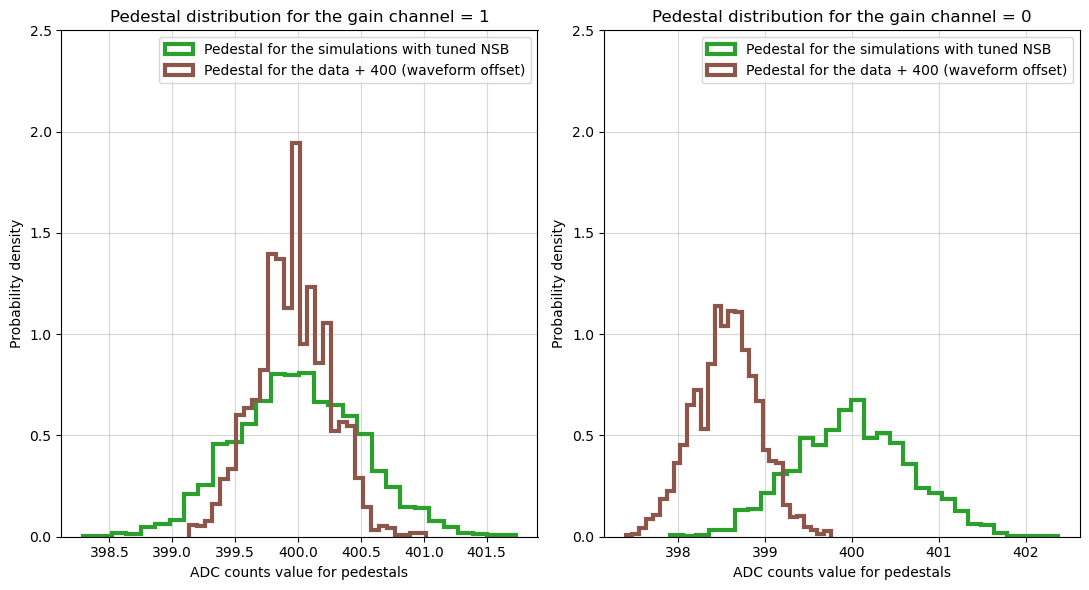

-1.4398626549865228

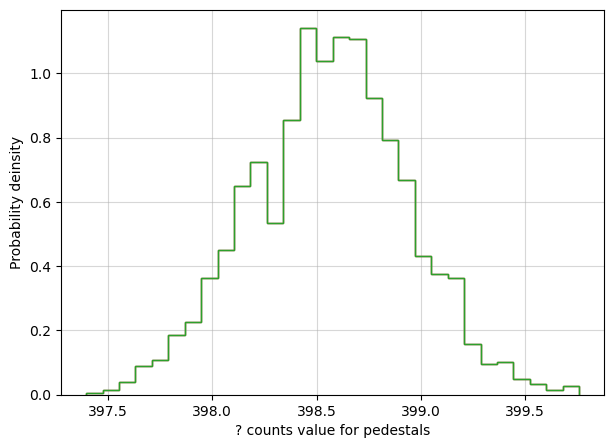

In [45]:
channel = 0
plt.figure(figsize=(7,5))
z,x,c = plt.hist(data_pedestal_1[channel]+400, histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(data_pedestal_2[channel]+400, histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(data_pedestal_3[channel]+400, histtype = 'step', bins = 30, density = True)

plt.grid(alpha = 0.5)
plt.xlabel("? counts value for pedestals")
plt.ylabel("Probability deinsity")
np.mean(data_pedestal_1[channel])

0.013068685175202155

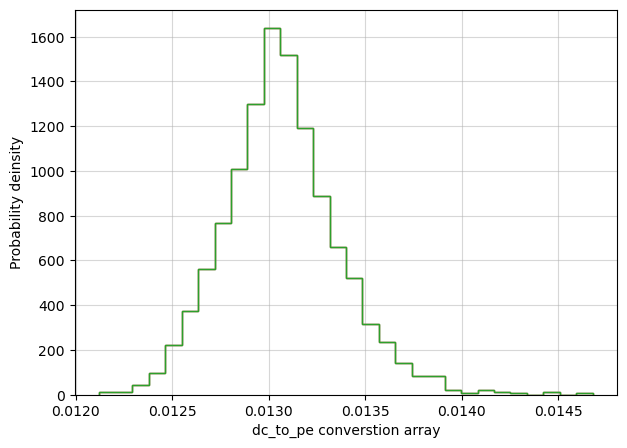

In [44]:
channel = 0
plt.figure(figsize=(7,5))
z,x,c = plt.hist(data_dc_to_pe_1[channel], histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(data_dc_to_pe_2[channel], histtype = 'step', bins = 30, density = True)
z,x,c = plt.hist(data_dc_to_pe_3[channel], histtype = 'step', bins = 30, density = True)

plt.grid(alpha = 0.5)
plt.xlabel("dc_to_pe converstion array")
plt.ylabel("Probability deinsity")
np.mean(data_dc_to_pe_1[channel])

In [5]:
data_waveform = np.loadtxt('/Users/vdk/muons2024/data/dc_to_pe_comparison/5_data_event.txt')
sim_waveform = np.loadtxt('/Users/vdk/muons2024/data/dc_to_pe_comparison/5_sim_event.txt')
print(f"min value in data {np.min(data_waveform)}")
print(f"min value in sim {np.min(sim_waveform)}")



min value in data -0.47552818059921265
min value in sim -0.5022032856941223


In [6]:
data_waveform.shape

(1855, 36)

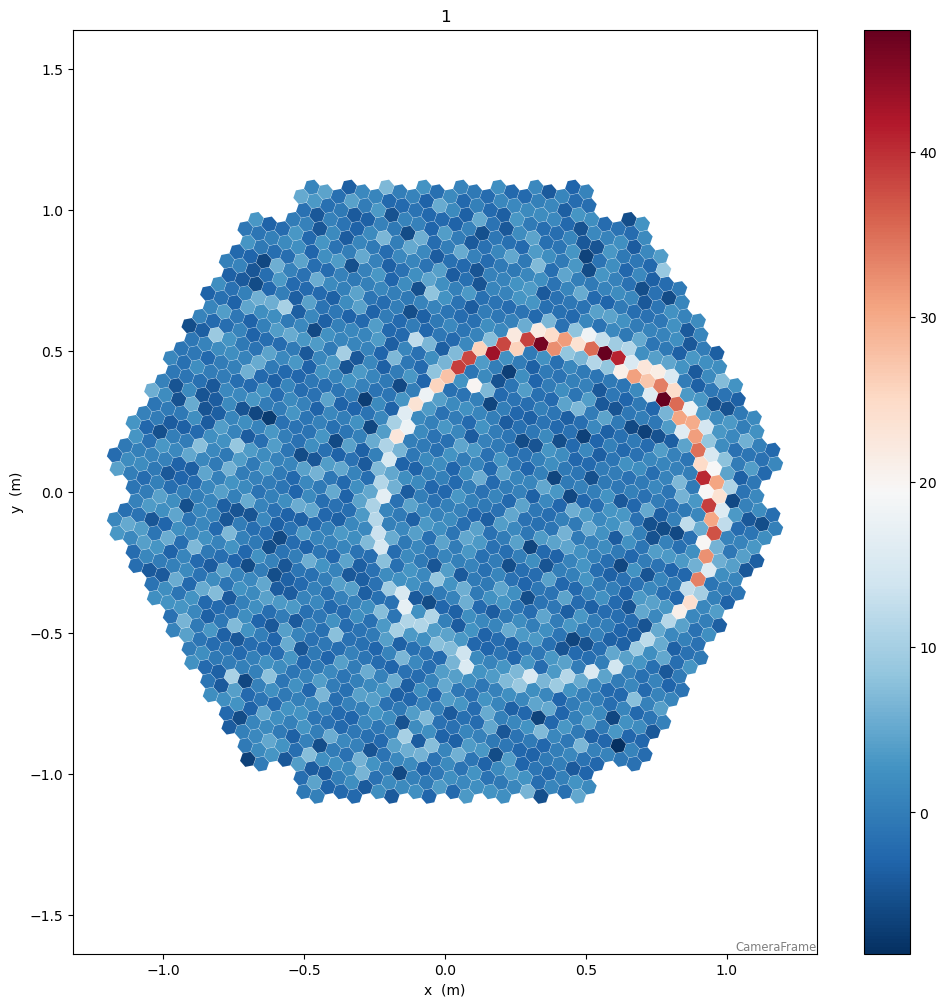

In [7]:

plt.figure(figsize = (12,12))
camgeom = source.subarray.tel[1].camera.geometry
#title="CT{}, run {} cog {} fit {} width {}".format(1,event.index.obs_id, round(event.dl1.tel[1].parameters.concentration.cog, 3), round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
disp = CameraDisplay(camgeom,title='1')
disp.image = data_waveform.sum(axis=1)
disp.image = sim_waveform.sum(axis=1)
#disp.image = j.r0.tel[1].waveform[0].sum(axis=1)        
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/TrurImageCheckCOG{i}_COG=0_fitWrong")
plt.show()

Text(0.5, 0, 'Time bin (ns)')

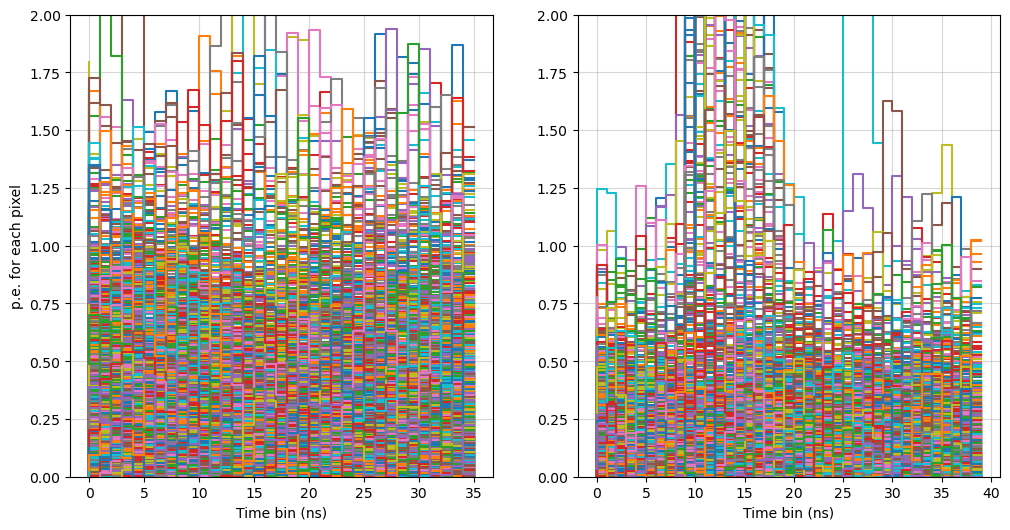

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

for pix_id in range(0,1855):
    ax1.plot(data_waveform[pix_id], drawstyle='steps')
    
for pix_id in range(0,1855):
    ax2.plot(sim_waveform[pix_id], drawstyle='steps')

ax1.set_ylim(0,2)
ax2.set_ylim(0,2)
ax1.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)
ax1.set_ylabel("p.e. for each pixel")
ax1.set_xlabel("Time bin (ns)")
ax2.set_xlabel("Time bin (ns)")


In [9]:
thresholds = np.array([1.5 for i in range(36)]) 
condition = np.all(data_waveform < thresholds, axis=1)
nsb_data = data_waveform[condition]

thresholds = np.array([1 for i in range(40)]) 
condition = np.all(sim_waveform < thresholds, axis=1)
nsb_sim = sim_waveform[condition]

print(nsb_data.shape)
print(nsb_sim.shape)

(1775, 36)
(1682, 40)


Text(0, 0.5, 'p.e./ns for each pixel')

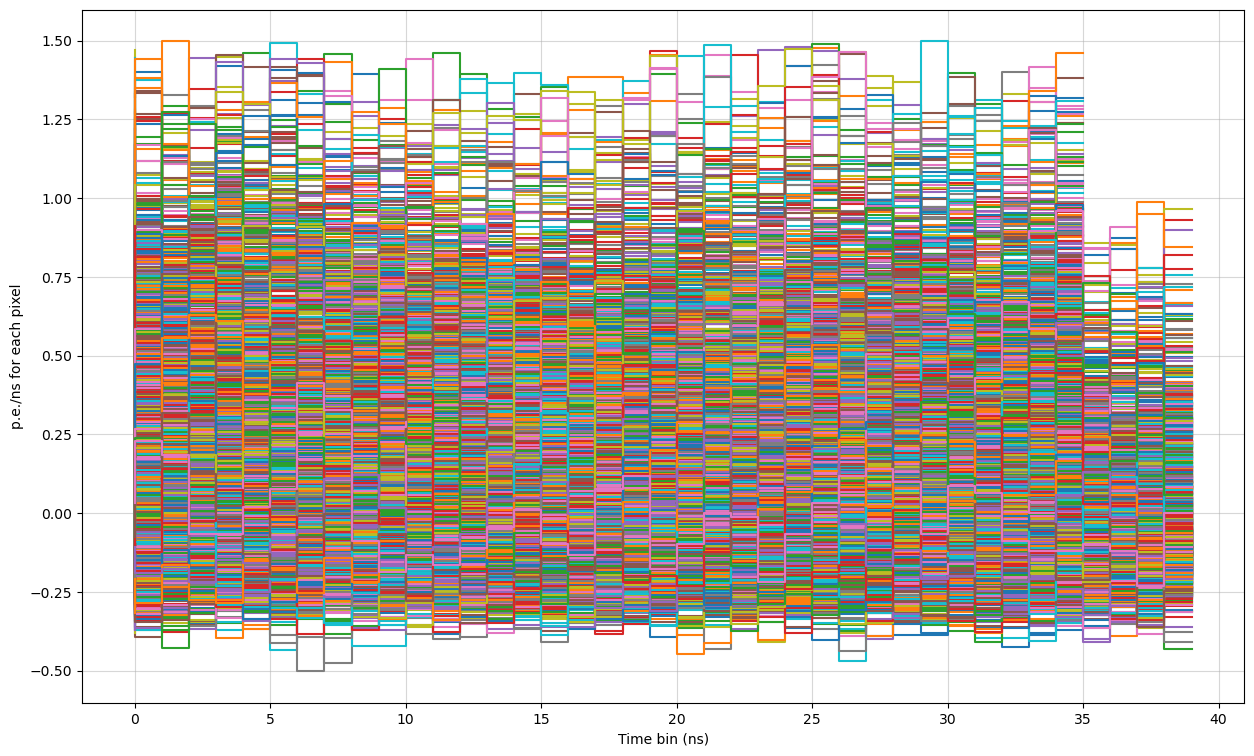

In [10]:
plt.figure(figsize = (15,9))
for pix_id in range(0,nsb_data.shape[0]):
    plt.plot(nsb_data[pix_id], drawstyle='steps')
    
for pix_id in range(0,nsb_sim.shape[0]):
    plt.plot(nsb_sim[pix_id], drawstyle='steps')

plt.grid(alpha = 0.5)
plt.xlabel("Time bin (ns)")
plt.ylabel("p.e./ns for each pixel")

Text(0.5, 1.0, 'Variance for pixels with charge  < 1.5 p.e')

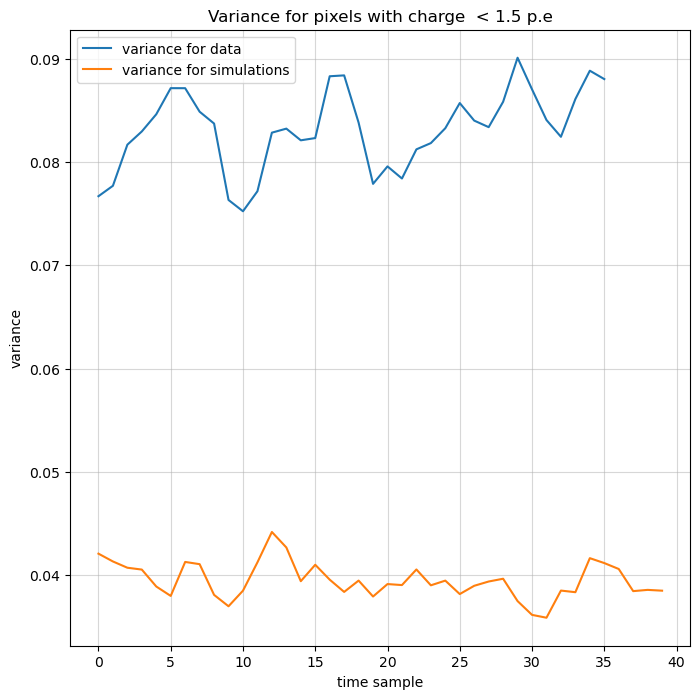

In [235]:
data_row_variances = np.var(nsb_data, axis=0)
sim_row_variances = np.var(nsb_sim, axis=0)
plt.figure(figsize=(8,8))
plt.plot(data_row_variances, label = "variance for data")
plt.plot(sim_row_variances, label = "variance for simulations")


plt.grid(alpha=0.5)

plt.xlabel("time sample")
plt.ylabel("variance")
plt.legend()
plt.title("Variance for pixels with charge  < 1.5 p.e")


In [236]:
print(f"Variance for data {np.var(nsb_data.flatten())}")
print(f"Variance for sim {np.var(nsb_sim.flatten())}")

Variance for data 0.08368620043660975
Variance for sim 0.039524868051889005


(array([  120.,  7376., 25791., 16507.,  9586.,  4800.,  1950.,   794.,
          264.,    92.]),
 array([-0.50220329, -0.35234642, -0.20248955, -0.05263269,  0.09722418,
         0.24708104,  0.39693791,  0.54679477,  0.69665164,  0.8465085 ,
         0.99636537]),
 <BarContainer object of 10 artists>)

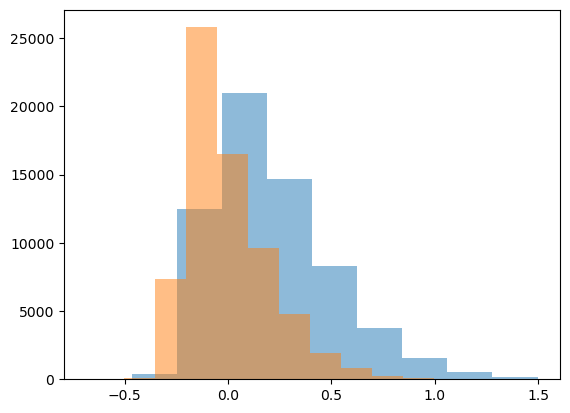

In [237]:
plt.hist(nsb_data.flatten(),alpha = 0.5)
plt.hist(nsb_sim.flatten(),alpha = 0.5)

Mean value of the x_axis = 8.258862378576064 
Standard deviation = 3.8905272503106665
Mean value of the x_axis = -0.06435942231493752 
Standard deviation = 2.9098376054568793


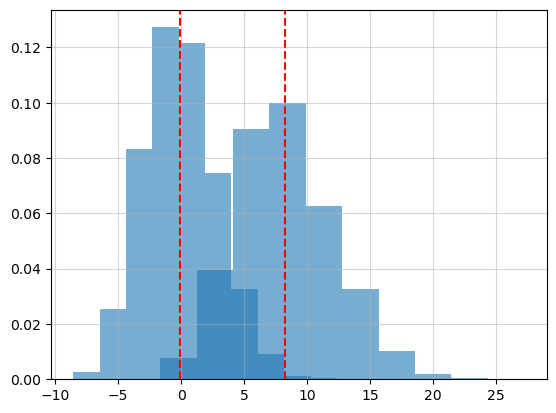

In [12]:
usefull_func.hist_wo_outliers(nsb_data.sum(axis=1), label = 'Data', density=True, mean_line=True, color = colors[0], alpha = 0.6)
usefull_func.hist_wo_outliers(nsb_sim.sum(axis=1), label = 'Simulations', density=True, mean_line=True, color = colors[0], alpha = 0.6)

In [13]:
nsb_data.shape

(1775, 36)

Text(0, 0.5, 'p.e./ns for each pixel')

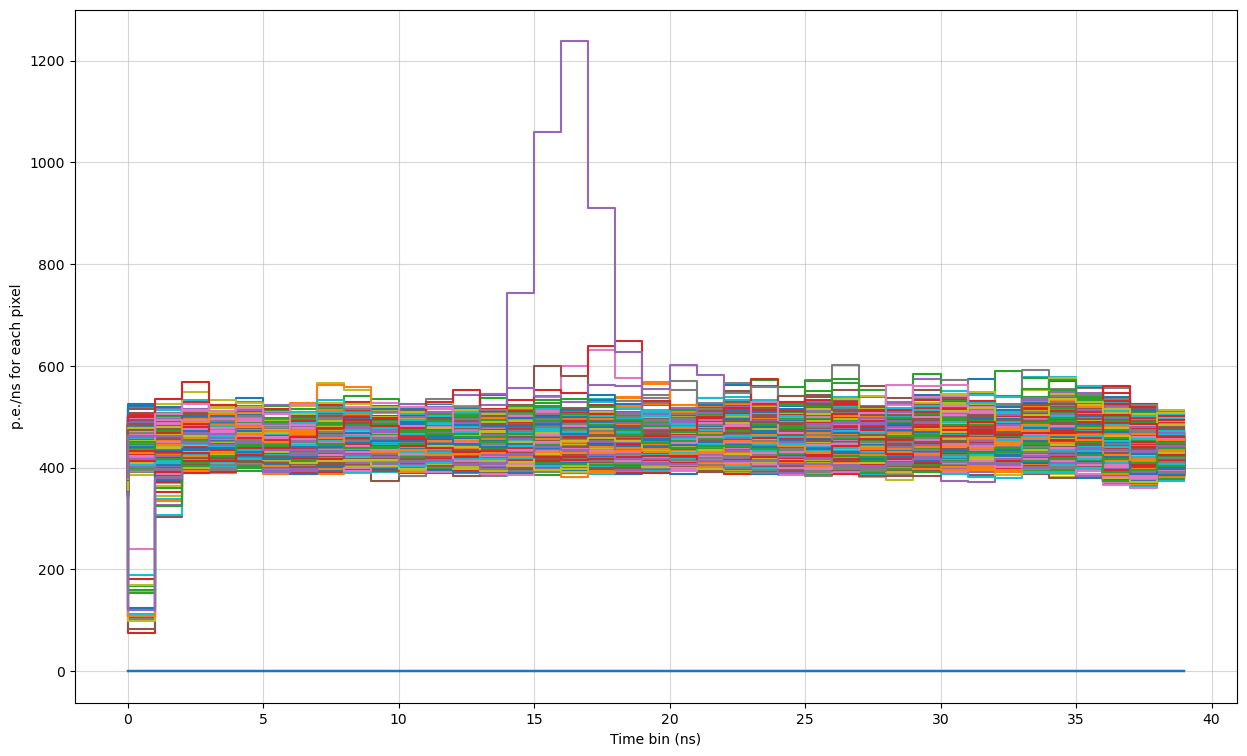

In [240]:
plt.figure(figsize = (15,9))
for pix_id in range(0,1855):
    plt.plot(r0_data_waveform[pix_id], drawstyle='steps')
    

plt.grid(alpha = 0.5)
plt.xlabel("Time bin (ns)")
plt.ylabel("p.e./ns for each pixel")

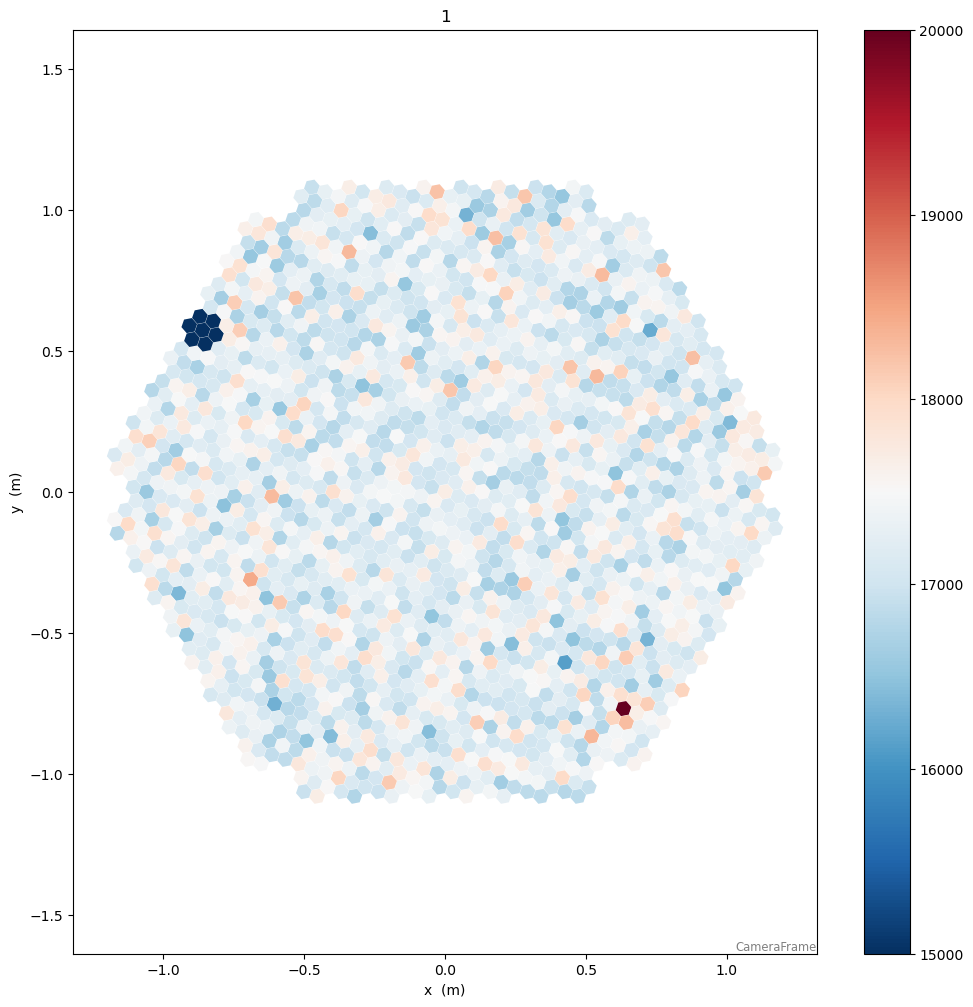

In [241]:
plt.figure(figsize = (12,12))
camgeom = source.subarray.tel[1].camera.geometry
#title="CT{}, run {} cog {} fit {} width {}".format(1,event.index.obs_id, round(event.dl1.tel[1].parameters.concentration.cog, 3), round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
disp = CameraDisplay(camgeom,title='1')
disp.image = r0_data_waveform.sum(axis=1)
#disp.image = sim_waveform.sum(axis=1)
#disp.image = j.r0.tel[1].waveform[0].sum(axis=1)        
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_minmax(15000,20000)
#plt.savefig(f"/Users/vdk/TrurImageCheckCOG{i}_COG=0_fitWrong")
plt.show()

In [242]:
np.max(data_waveform)

12.441749572753906

### Tuned

In [294]:
data_waveform = np.loadtxt('/Users/vdk/muons2024/data/dc_to_pe_comparison/3_data_20subrun_event.csv')
tuned_sim_waveform = np.loadtxt('/Users/vdk/muons2024/data/dc_to_pe_comparison/1_sim_tuned_event.csv')
print(f"min value in data {np.min(data_waveform)}")
print(f"min value in sim {np.min(sim_waveform)}")

min value in data -0.684537947177887
min value in sim -0.5022032856941223


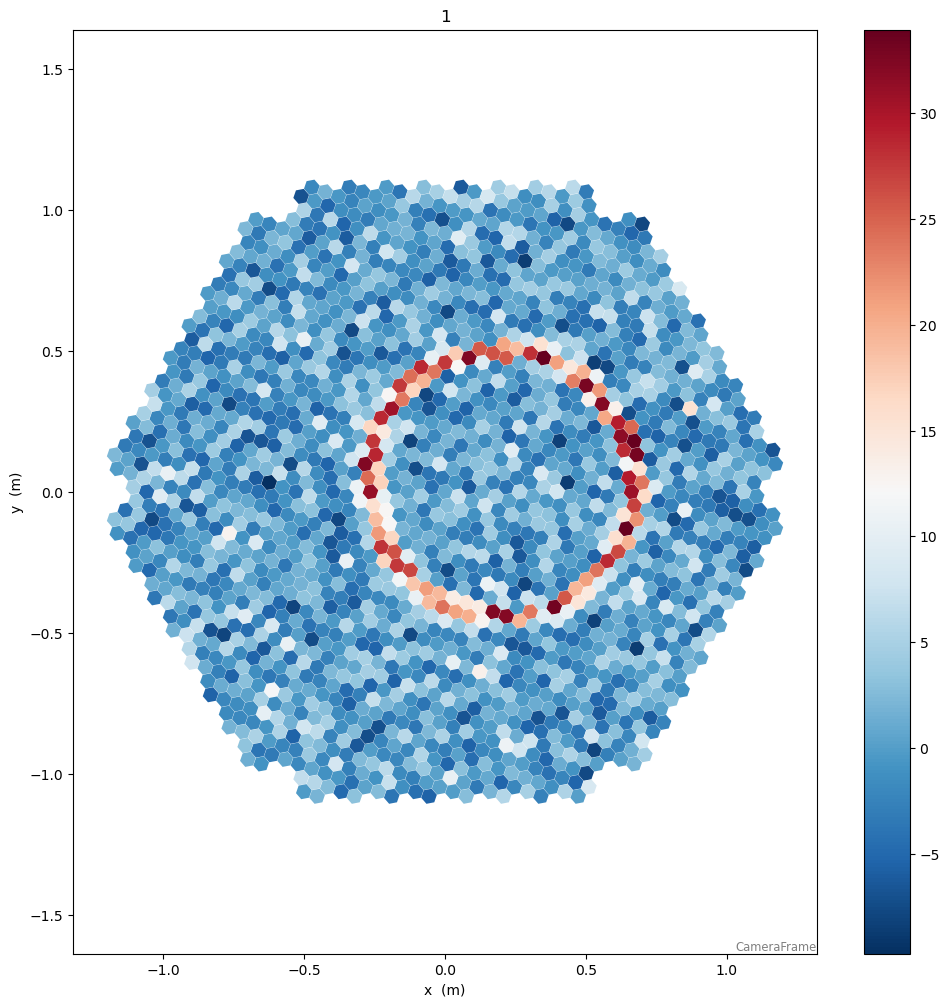

In [295]:

plt.figure(figsize = (12,12))
camgeom = source.subarray.tel[1].camera.geometry
#title="CT{}, run {} cog {} fit {} width {}".format(1,event.index.obs_id, round(event.dl1.tel[1].parameters.concentration.cog, 3), round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
disp = CameraDisplay(camgeom,title='1')
disp.image = data_waveform.sum(axis=1)
disp.image = tuned_sim_waveform.sum(axis=1)
#disp.image = j.r0.tel[1].waveform[0].sum(axis=1)        
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/TrurImageCheckCOG{i}_COG=0_fitWrong")
plt.show()

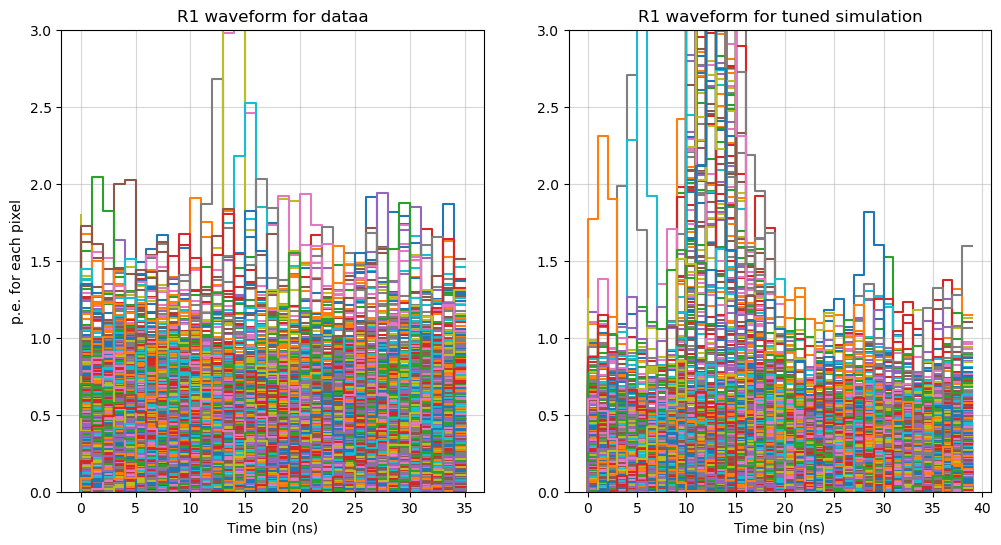

In [400]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

for pix_id in range(0,1855):
    ax1.plot(data_waveform[pix_id], drawstyle='steps')
    
for pix_id in range(0,1855):
    ax2.plot(tuned_sim_waveform[pix_id], drawstyle='steps')

ax1.set_ylim(0,3)
ax2.set_ylim(0,3)
ax1.grid(alpha = 0.5)
ax1.set_title("R1 waveform for dataa")
ax2.grid(alpha = 0.5)
ax1.set_ylabel("p.e. for each pixel")
ax1.set_xlabel("Time bin (ns)")
ax2.set_xlabel("Time bin (ns)")
ax2.set_title("R1 waveform for tuned simulation")
#plt.title("Left: Data; Right: Simulations with Tuned NSB")
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/data_vs_tuned_sim_waveform.pdf', dpi = 200)

(1713, 36)
(1737, 40)
(1724, 40)
Variance for data 0.0819636404104607
Variance for sim 0.042082333285576506
Variance for tuned sim 0.06415090920436524


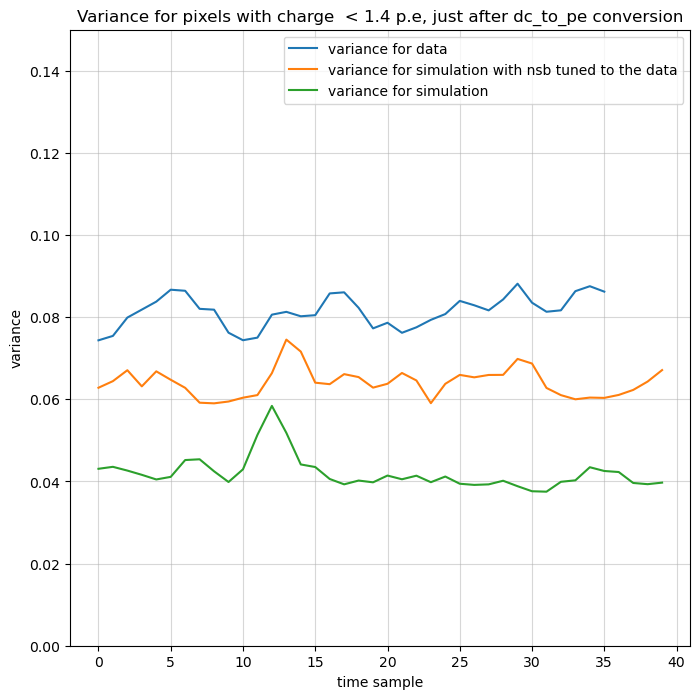

In [297]:
cut_threshold = 1.4
thresholds = np.array([cut_threshold for i in range(36)]) 
condition = np.all(data_waveform < thresholds, axis=1)
nsb_data = data_waveform[condition]

thresholds = np.array([cut_threshold for i in range(40)]) 
condition = np.all(sim_waveform < thresholds, axis=1)
nsb_sim = sim_waveform[condition]

thresholds = np.array([cut_threshold for i in range(40)]) 
condition = np.all(tuned_sim_waveform < thresholds, axis=1)
tuned_nsb_sim = tuned_sim_waveform[condition]

print(nsb_data.shape)
print(nsb_sim.shape)
print(tuned_nsb_sim.shape)
data_row_variances = np.var(nsb_data, axis=0)
tuned_sim_row_variances = np.var(tuned_nsb_sim, axis=0)
sim_row_variances = np.var(nsb_sim, axis=0)
plt.figure(figsize=(8,8))
plt.plot(data_row_variances, label = "variance for data")
plt.plot(tuned_sim_row_variances, label = "variance for simulation with nsb tuned to the data")
plt.plot(sim_row_variances, label = "variance for simulation")


plt.grid(alpha=0.5)


plt.ylim(0.0,0.15)
plt.xlabel("time sample")
plt.ylabel("variance")
plt.legend()
plt.title(f"Variance for pixels with charge  < {cut_threshold} p.e, just after dc_to_pe conversion")


print(f"Variance for data {np.var(nsb_data.flatten())}")
print(f"Variance for sim {np.var(nsb_sim.flatten())}")
print(f"Variance for tuned sim {np.var(tuned_nsb_sim.flatten())}")

In [299]:
nsb_data.shape

(1713, 36)

In [273]:
0.06431668311798179 / 0.08368620043660975

0.7685458627877377

### Larger statistic

In [4]:
tuned_sim_files = glob.glob('/Users/vdk/muons2024/data/dc_to_pe_comparison/tuned_simulations/*')
data_files = glob.glob('/Users/vdk/muons2024/data/dc_to_pe_comparison/17043_subrun20/*')
sim_files = glob.glob('/Users/vdk/muons2024/data/dc_to_pe_comparison/simulations/*')
double_tuned_files = glob.glob('/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/*')

data_waveforms = []
tune_sim_waveforms = []
double_tuned_waveforms = []
sim_waveforms = []

for file_name in tuned_sim_files:
    tune_sim_waveforms.append(
        np.loadtxt(file_name)
    )

for file_name in sim_files:
    sim_waveforms.append(
        np.loadtxt(file_name)
    )

for file_name in data_files:
    data_waveforms.append(
        np.loadtxt(file_name)
    )
    
for file_name in double_tuned_files:
    double_tuned_waveforms.append(
        np.loadtxt(file_name)
    )


In [422]:
sim_files

['/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event288_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event411_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event695_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event666_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event468_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event202_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event991_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event962_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event843_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc_to_pe_comparison/triple_tuned_sim/event549_triple_tuned_sim.csv',
 '/Users/vdk/muons2024/data/dc

Text(0.5, 1.0, 'Mean of the variance for pixels with charge  < 1.3 p.e, just after dc_to_pe conversion')

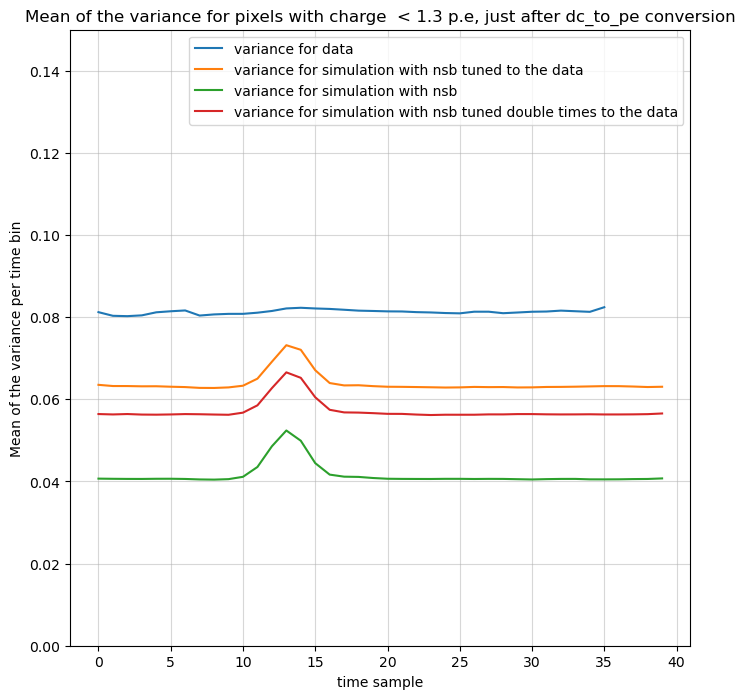

In [428]:
cut_threshold = 1.3

thresholds = np.array([cut_threshold for i in range(40)]) 
tuned_sim_row_variances = []
for waveform in tune_sim_waveforms:
    condition = np.all(waveform < thresholds, axis=1)
    tuned_sim_row_variances.append(np.var(waveform[condition], axis=0))
    
    
thresholds = np.array([cut_threshold for i in range(36)]) 
data_row_variances = []
for waveform in data_waveforms:
    condition = np.all(waveform < thresholds, axis=1)
    data_row_variances.append(np.var(waveform[condition], axis=0))

  
thresholds = np.array([cut_threshold for i in range(40)]) 
sim_row_variances = []
for waveform in sim_waveforms:
    condition = np.all(waveform < thresholds, axis=1)
    sim_row_variances.append(np.var(waveform[condition], axis=0))

double_tuned_sim_row_variances = []
for waveform in double_tuned_waveforms:
    condition = np.all(waveform < thresholds, axis=1)
    double_tuned_sim_row_variances.append(np.var(waveform[condition], axis=0))

mean_var_tuned_sim = np.mean(np.array(tuned_sim_row_variances), axis = 0)
mean_var_double_tuned_sim = np.mean(np.array(double_tuned_sim_row_variances), axis = 0)
mean_var_sim = np.mean(np.array(sim_row_variances), axis = 0)
mean_var_data = np.mean(np.array(data_row_variances), axis = 0)

plt.figure(figsize=(8,8))
plt.plot(mean_var_data, label = "variance for data")
plt.plot(mean_var_tuned_sim, label = "variance for simulation with nsb tuned to the data")
plt.plot(mean_var_sim, label = "variance for simulation with nsb")
plt.plot(mean_var_double_tuned_sim, label = "variance for simulation with nsb tuned double times to the data")

plt.grid(alpha=0.5)


plt.ylim(0.0,0.15)
plt.xlabel("time sample")
plt.ylabel("Mean of the variance per time bin")
plt.legend()
plt.title(f"Mean of the variance for pixels with charge  < {cut_threshold} p.e, just after dc_to_pe conversion")
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/Variance_1000_events_cut<1.3pe.pdf', dpi = 200)

Mean value of the variance for data 0.081 with std = 0.007
Mean value of the variance for simulations 0.057 with std = 0.004
Mean value of the variance for tuned simulations 0.064 with std = 0.004


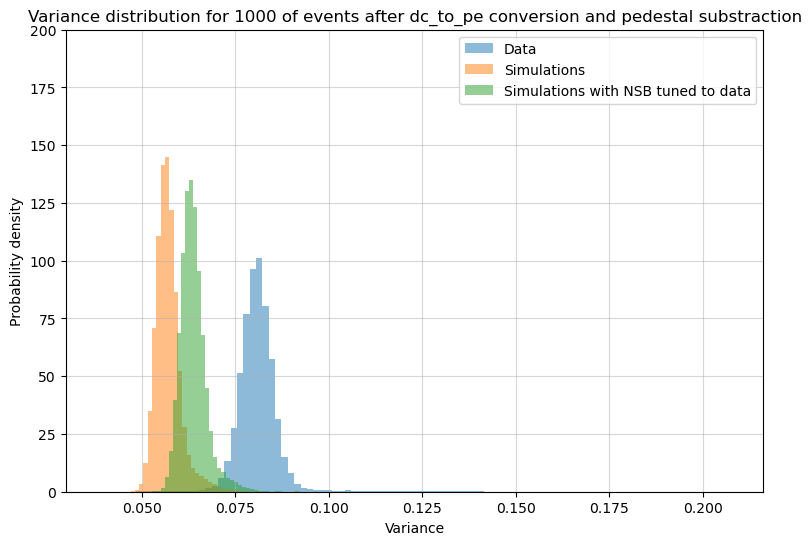

In [425]:
plt.figure(figsize=(9,6))
x,y,c = plt.hist(np.array(data_row_variances).flatten(), bins = 100, density=True, alpha = 0.5, label = 'Data')
x,y,c = plt.hist(np.array(sim_row_variances).flatten(), bins = 100, density=True, alpha = 0.5, label = 'Simulations')
x,y,c = plt.hist(np.array(tuned_sim_row_variances).flatten(), bins = 100, density=True, alpha = 0.5, label = 'Simulations with NSB tuned to data')
plt.grid(alpha = 0.5)
plt.ylim(0,200)
plt.xlabel('Variance')
plt.ylabel('Probability density')
plt.title('Variance distribution for 1000 of events after dc_to_pe conversion and pedestal substraction')
plt.legend()
print(f"Mean value of the variance for data {round(np.mean(np.array(data_row_variances).flatten()),3)} with std = {round(np.std(np.array(data_row_variances).flatten()), 3)}")
print(f"Mean value of the variance for simulations {round(np.mean(np.array(sim_row_variances).flatten()),3)} with std = {round(np.std(np.array(sim_row_variances).flatten()),3)}")
print(f"Mean value of the variance for tuned simulations {round(np.mean(np.array(tuned_sim_row_variances).flatten()),3)} with std = {round(np.std(np.array(tuned_sim_row_variances).flatten()),3)}")
#plt.savefig('/Users/vdk/muons2024/images/PlanPaper/Variance_1000_events_cut<1.3pe_histogram.pdf', dpi = 200)

Number of outliers = 48270
Mean value of the x_axis = 1.0177909736840545 
Standard deviation = 5.369156149063318
Number of outliers = 17734
Mean value of the x_axis = 3.999819926874863 
Standard deviation = 5.073929038876786


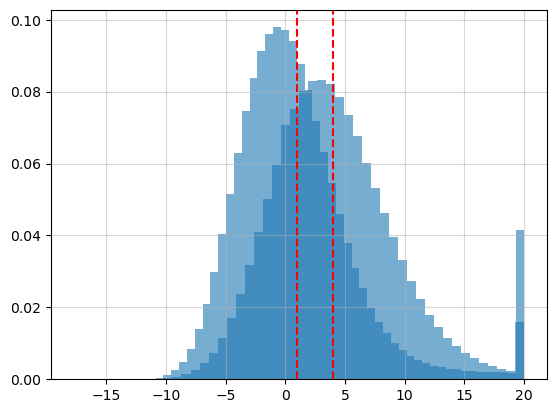

In [26]:
usefull_func.hist_wo_outliers(np.array(tune_sim_waveforms).reshape(-1, 40).sum(axis=1), outlier_value=20, show_outliers=True,label = 'Data', density=True, mean_line=True, color = colors[0], alpha = 0.6, bins = 50)
usefull_func.hist_wo_outliers(np.array(data_waveforms).reshape(-1, 40).sum(axis=1), outlier_value=20, show_outliers=True, label = 'Data', density=True, mean_line=True, color = colors[0], alpha = 0.6, bins = 50)

In [18]:
np.array(tune_sim_waveforms).reshape(-1, 40).shape

(1855000, 40)